This notebook generates results for traffic_stop_0202.doc

This notebook contains:


1.   Baseline Model (include variables: micropolitan, metropolitan, race-related, holiday)
2.   Interaction Term Model (include variables: micropolitan, metropolitan, race-related, holiday and interactions of every race with metropolitan (since micropolitan is not significant)). For confidence interval, you would have two CIs for each race (metro vs. not metro, respectively).
3.   Baseline Model and Interaction model for speed_school zone <- all year combined. (if possible, make this an API that we can choose violation types)
4.   Demographic (race) distribution for search_conducted under only speeding violation
5.   Demographic (race) distribution for the only violation is 'speeding over limit' category



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
import os 
drive.mount('/gdrive/')

Mounted at /gdrive/


In [3]:
data = pd.read_parquet('/gdrive/MyDrive/traffic_stop/year_data_preprocessed/traffic_2016.parquet', engine = 'pyarrow')
data.head()

,date,time,lat,lng,county_name,subject_race,subject_sex,violation,citation_issued,contraband_found,contraband_drugs,contraband_weapons,search_conducted,search_vehicle,all_violation,speeding_only,county_type,sunset,sunrise,dawn,dusk,stop_time,light_cat,holiday
0,2016-01-01,00:04:00,29.955355,-97.877880,Hays County,white,female,speeding over limit,0,0,0,0,0,0,[speeding over limit],speeding-1,Metropolitan,2016-01-01 17:42:32,2016-01-01 07:27:28,2016-01-01 07:00:42,2016-01-01 18:09:18,2016-01-01 00:04:00,dark,1
1,2016-01-01,00:06:00,32.717438,-97.388130,Tarrant County,white,male,speeding over limit,0,0,0,0,0,0,[speeding over limit],speeding-1,Metropolitan,2016-01-01 17:34:05,2016-01-01 07:32:01,2016-01-01 07:04:19,2016-01-01 18:01:47,2016-01-01 00:06:00,dark,1
2,2016-01-01,00:09:00,32.502914,-94.710304,Gregg County,white,male,speeding over limit,0,0,0,0,0,0,[speeding over limit],speeding-1,Metropolitan,2016-01-01 17:23:53,2016-01-01 07:20:47,2016-01-01 06:53:09,2016-01-01 17:51:30,2016-01-01 00:09:00,dark,1
3,2016-01-01,00:09:00,28.945862,-96.711410,Jackson County,hispanic,female,speeding over limit,0,0,0,0,0,0,[speeding over limit],speeding-1,Non core,2016-01-01 17:40:09,2016-01-01 07:20:31,2016-01-01 06:54:03,2016-01-01 18:06:37,2016-01-01 00:09:00,dark,1
4,2016-01-01,00:10:00,30.459875,-93.962875,Jasper County,asian/pacific islander,male,speeding over limit,0,0,0,0,0,0,[speeding over limit],speeding-1,Non core,2016-01-01 17:25:43,2016-01-01 07:12:57,2016-01-01 06:46:02,2016-01-01 17:52:39,2016-01-01 00:10:00,dark,1


In [4]:
data['subject_race'].value_counts()

white                     325374
hispanic                  171879
black                      48600
asian/pacific islander      8251
other                          0
unknown                        0
Name: subject_race, dtype: int64

In [5]:
data['speeding_only'].value_counts()

speeding-1                   554002
speeding-repeated_entries       102
Name: speeding_only, dtype: int64

In [6]:
data['violation'].value_counts()

speeding over limit                                                                                 550578
speeding-school zone                                                                                  2757
speeding - zoned (inclement weather, signs posted, military zone, beach)                               688
any speedometer violation                                                                               33
speed under minimum                                                                                     30
increase speed while being overtaken                                                                    10
speeding (over 35 mph) motor driven cycle (effective 1/1/2000 for arrests issued after 1/1/2000)         7
speeding-zoned (posted below 55) (do not use on arrests after 12/31/1999)                                1
Name: violation, dtype: int64

In [7]:
len(data)

554104

In [ ]:
week_day = data['date'].map(lambda x: x.weekday())
week_day = pd.Series(week_day)
week_day.value_counts()

5    99415
4    86594
6    78218
2    74425
3    73289
0    71295
1    70868
Name: date, dtype: int64

In [ ]:
data['light_cat'].value_counts()

light         386787
dark          119130
half_light     48187
Name: light_cat, dtype: int64

In [ ]:
data.columns

Index(['date', 'time', 'lat', 'lng', 'county_name', 'subject_race',
       'subject_sex', 'violation', 'citation_issued', 'contraband_found',
       'contraband_drugs', 'contraband_weapons', 'search_conducted',
       'search_vehicle', 'all_violation', 'speeding_only', 'county_type',
       'sunset', 'sunrise', 'dawn', 'dusk', 'stop_time', 'light_cat',
       'holiday'],
      dtype='object')

### Baseline Model & Interaction-Term model

In [ ]:
data['holiday'].value_counts()

0    322573
1    231531
Name: holiday, dtype: int64

In [8]:
#### MODIFY HERE!! GET LIST OF COLUMN NAMES
#var_lst_interaction = ['subject_race_black', 'subject_race_hispanic', 'subject_race_asian/pacific islander',
                    #'holiday', 'county_type_Metropolitan', 'county_type_Micropolitan',
                    #'hispanic_metro','black_metro','asian/paci_metro']

var_lst_baseline = ['subject_race_black', 'subject_race_hispanic', 'subject_race_asian/pacific islander',
                    'holiday', 'county_type_Metropolitan', 'county_type_Micropolitan']

# num_feat = len(df_16.columns)

# this df is later pass into run_year_analysis to get all estimates
#df_years = pd.DataFrame({'variable':var_lst_interaction})
df_years = pd.DataFrame({'variable':var_lst_baseline})

# keep track of coefficient estimates and evaluation metrics
asianpacific = []	
black = []	
hispanic = []	

asianpacific_low = []	
black_low = []	
hispanic_low = []

asianpacific_high = []	
black_high = []	
hispanic_high = []

def run_year_analysis(data_path, output_path,df_years, model, school = False):
  """
  Input:
  #data_path: the folder path where all the yearly-based parquet files are saved

  #output_path: output path for csv files -> not used yet, because I want to print out the result and directly 
  #save it afterwards. After we make sure there is no problem about how I did the analysis, we integrate this part
  #into the function

  keep_col, rm_na_col,violation_type: parameters for preprocessing
  df_years: an empty data frame where we can save the logistic regression results
  model: 'baseline' or 'interaction'
  Output:
  A result dataframe
  """

  years = list(range(2006, 2018))
  
  for year in years:
    # read in and preprocess the data
    if school == False:
      print('***********************************')
      print(year)
      filename = '/gdrive/MyDrive/traffic_stop/year_data_preprocessed/traffic_' + str(year) + '.parquet'
      df = pd.read_parquet(filename, engine = 'pyarrow')
      df = df.loc[df['violation'] == 'speeding over limit',:]
      print('# speeding over limit: ', len(df))
    if school == True:
      print('***********************************')
      print('school zone')
      df = pd.DataFrame()
      for year in years:
        filename = '/gdrive/MyDrive/traffic_stop/year_data_preprocessed/traffic_' + str(year) + '.parquet'
        df_temp = pd.read_parquet(filename, engine = 'pyarrow')
        df_temp = df_temp.loc[df_temp['violation'] == 'speeding-school zone',:]
        df = pd.concat([df,df_temp], ignore_index = True)
      print('# of school zone speeding:', len(df))
      print(df['citation_issued'].value_counts())

    y = df['citation_issued']
    X = df.drop('citation_issued', axis = 1)
    X.drop(['sunset','sunrise','dawn','dusk','stop_time','time','lat','lng','date','county_name'], 
           axis = 1, inplace = True)
    X['subject_race'] = df.subject_race.cat.remove_unused_categories()
    # note that in some columns, we could have all 0 values, this makes the matrix singular and cannot run logistic regression
    
    # Those columns also contain no useful information. So, we drop those columns
    #for col in X.columns:
      #if len(X.loc[X[col] == 0,:]) == len(X):
        #X.drop(col, axis = 1, inplace = True)
        #print(year, ': ','Delete ', col)

    # ADD HERE !!!!!!!!!!!!!!
    # drop variables not used
    X.drop(['contraband_found','contraband_drugs','contraband_weapons','search_conducted',
              'subject_sex','light_cat', 'violation', 'search_vehicle', 'all_violation',
              'speeding_only'], axis = 1, inplace = True)
    
    # get dummies for race, sex, daylight,holiday
    X = pd.get_dummies(X)

    print(X.columns)

    # for baseline model
    if model == 'baseline':
      # Base level: White, Non_core (county type), holiday = 0
      X.drop(['subject_race_white', 'county_type_Non core'], axis = 1, inplace = True)

    # for interaction model
    if model == 'interaction':
      # Base level: White, Non_core (county type), holiday = 0
      X.drop(['subject_race_white', 'county_type_Non core'], axis = 1, inplace = True)
      
      X['hispanic_metro'] = X['subject_race_hispanic'] * X['county_type_Metropolitan']
      X['black_metro'] = X['subject_race_black'] * X['county_type_Metropolitan']
      X['asian/paci_metro'] = X['subject_race_asian/pacific islander'] * X['county_type_Metropolitan']

    #adding constant to X
    X_with_constant = sm.add_constant(X)
    # building the model and fitting the data
    log_reg = sm.Logit(y, X_with_constant).fit()
    
    res_df = pd.DataFrame({'variable':list(log_reg.params.index), 'coef':list(log_reg.params.values), 
                           'odds_ratio':list(np.exp(log_reg.params.values)),
                           'lower_CI':list(np.exp(log_reg.conf_int()[0].values)),
                           'upper_CI':list(np.exp(log_reg.conf_int()[1].values)),'pvalue':list(log_reg.pvalues)})
    if school == True:
      return res_df
    df_years = df_years.merge(res_df, left_on = 'variable', right_on = 'variable', how = 'outer')
    df_years = df_years.rename(columns = {'coef': ('coef_' + str(year)), 
                                          'odds_ratio': ('odds_ratio_' + str(year)),
                                          'lower_CI': ('OR_lower_CI_' + str(year)),
                                          'upper_CI': ('OR_upper_CI_' + str(year)), 
                                          'pvalue': ('pvalue_' + str(year))})

    # append race coefs to result list for plotting
    black.append(np.exp(log_reg.params['subject_race_black']))
    hispanic.append(np.exp(log_reg.params['subject_race_hispanic']))
    asianpacific.append(np.exp(log_reg.params['subject_race_asian/pacific islander']))

    # lower CI
    black_low.append(np.exp(log_reg.conf_int()[0]['subject_race_black']))
    hispanic_low.append(np.exp(log_reg.conf_int()[0]['subject_race_hispanic']))
    asianpacific_low.append(np.exp(log_reg.conf_int()[0]['subject_race_asian/pacific islander']))

    # upper CI
    black_high.append(np.exp(log_reg.conf_int()[1]['subject_race_black']))
    hispanic_high.append(np.exp(log_reg.conf_int()[1]['subject_race_hispanic']))
    asianpacific_high.append(np.exp(log_reg.conf_int()[1]['subject_race_asian/pacific islander']))

  return df_years

# write result df to csv file


#### speeding-over-limit baseline

In [9]:
#var_lst_interaction = ['subject_race_black', 'subject_race_hispanic', 'subject_race_asian/pacific islander',
                    #'holiday', 'county_type_Metropolitan', 'county_type_Micropolitan',
                    #'hispanic_metro','black_metro','asian/paci_metro']

var_lst_baseline = ['subject_race_black', 'subject_race_hispanic', 'subject_race_asian/pacific islander',
                    'holiday', 'county_type_Metropolitan', 'county_type_Micropolitan']

# num_feat = len(df_16.columns)

# this df is later pass into run_year_analysis to get all estimates
#df_years = pd.DataFrame({'variable':var_lst_interaction})
df_years = pd.DataFrame({'variable':var_lst_baseline})

# keep track of coefficient estimates and evaluation metrics
asianpacific = []	
black = []	
hispanic = []	

asianpacific_low = []	
black_low = []	
hispanic_low = []

asianpacific_high = []	
black_high = []	
hispanic_high = []

In [10]:
data_path = '/gdrive/MyDrive/traffic_stop/year_data_preprocessed/'
res_df = run_year_analysis(data_path, output_path = ' ', df_years = df_years, school = False, model = 'baseline')

***********************************
2006
# speeding over limit:  759993
Index(['holiday', 'subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_race_white',
       'county_type_Metropolitan', 'county_type_Micropolitan',
       'county_type_Non core'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.018495
         Iterations 10
***********************************
2007
# speeding over limit:  692057
Index(['holiday', 'subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_race_white',
       'county_type_Metropolitan', 'county_type_Micropolitan',
       'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.016761
         Iterations 10
***********************************
2008
# speeding over limit:  756961
Index(['holiday', 'subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_race_white',
       'county_type_Metropolitan', 'county_type_Micropolitan',
       'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.016730
         Iterations 10
***********************************
2009
# spee

In [11]:
res_df

,variable,coef_2006,odds_ratio_2006,OR_lower_CI_2006,OR_upper_CI_2006,pvalue_2006,coef_2007,odds_ratio_2007,OR_lower_CI_2007,OR_upper_CI_2007,pvalue_2007,coef_2008,odds_ratio_2008,OR_lower_CI_2008,OR_upper_CI_2008,pvalue_2008,coef_2009,odds_ratio_2009,OR_lower_CI_2009,OR_upper_CI_2009,pvalue_2009,coef_2010,odds_ratio_2010,OR_lower_CI_2010,OR_upper_CI_2010,pvalue_2010,coef_2011,odds_ratio_2011,OR_lower_CI_2011,OR_upper_CI_2011,pvalue_2011,coef_2012,odds_ratio_2012,OR_lower_CI_2012,OR_upper_CI_2012,pvalue_2012,coef_2013,odds_ratio_2013,OR_lower_CI_2013,OR_upper_CI_2013,pvalue_2013,coef_2014,odds_ratio_2014,OR_lower_CI_2014,OR_upper_CI_2014,pvalue_2014,coef_2015,odds_ratio_2015,OR_lower_CI_2015,OR_upper_CI_2015,pvalue_2015,coef_2016,odds_ratio_2016,OR_lower_CI_2016,OR_upper_CI_2016,pvalue_2016,coef_2017,odds_ratio_2017,OR_lower_CI_2017,OR_upper_CI_2017,pvalue_2017
0,subject_race_black,-0.043803,0.957142,0.813429,1.126246,0.597708,0.065708,1.067915,0.893768,1.275994,4.694074e-01,-0.034071,0.966503,0.806499,1.158250,7.121420e-01,0.112079,1.118602,0.894327,1.399120,3.262413e-01,0.166901,1.181637,0.927569,1.505296,1.766198e-01,-0.005772,0.994245,0.781472,1.264950,9.625316e-01,0.038452,1.039201,0.920702,1.172951,5.336278e-01,-0.198947,0.819593,0.720277,0.932603,2.538729e-03,-0.015208,0.984907,0.843054,1.150628,8.480023e-01,0.042537,1.043454,0.844612,1.289109,6.933249e-01,-0.142566,0.867131,0.685033,1.097635,2.358645e-01,-0.003594,0.996412,0.764720,1.298302,9.787636e-01
1,subject_race_hispanic,0.251278,1.285668,1.149756,1.437645,0.000010,0.472697,1.604316,1.429499,1.800512,9.733398e-16,-0.034082,0.966492,0.845880,1.104301,6.162686e-01,0.816937,2.263556,2.013785,2.544306,1.095692e-42,0.683695,1.981185,1.726241,2.273780,2.290650e-22,0.698368,2.010468,1.772005,2.281023,2.194715e-27,0.617430,1.854157,1.732913,1.983885,1.303716e-71,0.223338,1.250243,1.163043,1.343981,1.407994e-09,0.170648,1.186074,1.083000,1.298957,2.342076e-04,0.141641,1.152163,1.015676,1.306991,2.768241e-02,0.122884,1.130753,0.992765,1.287921,6.422643e-02,0.269178,1.308888,1.131922,1.513520,2.812841e-04
2,subject_race_asian/pacific islander,0.396482,1.486586,1.000288,2.209301,0.049834,0.740618,2.097231,1.457825,3.017081,6.566655e-05,0.657963,1.930856,1.397616,2.667546,6.604410e-05,0.572681,1.773015,1.168548,2.690160,7.098051e-03,0.517199,1.677322,1.060051,2.654032,2.717135e-02,0.445123,1.560683,1.028231,2.368855,3.655253e-02,0.672944,1.959999,1.611445,2.383944,1.630776e-11,0.675210,1.964445,1.623374,2.377174,3.934187e-12,0.388608,1.474926,1.117145,1.947291,6.117193e-03,-0.181432,0.834075,0.507700,1.370261,4.737994e-01,0.318253,1.374724,0.889276,2.125173,1.521536e-01,0.602090,1.825931,1.177447,2.831569,7.152041e-03
3,holiday,-0.128450,0.879458,0.804635,0.961237,0.004634,-0.198931,0.819607,0.743015,0.904094,7.063025e-05,-0.043324,0.957601,0.872420,1.051100,3.620494e-01,-0.221227,0.801535,0.715884,0.897432,1.246414e-04,-0.141949,0.867666,0.761748,0.988310,3.259888e-02,0.047083,1.048209,0.930283,1.181083,4.394023e-01,-0.070454,0.931970,0.874685,0.993007,2.949756e-02,0.042117,1.043017,0.979354,1.110817,1.899515e-01,-0.020094,0.980107,0.902798,1.064035,6.317033e-01,-0.049769,0.951449,0.845504,1.070669,4.086413e-01,0.069316,1.071775,0.950549,1.208460,2.577018e-01,-0.076059,0.926762,0.806930,1.064389,2.816390e-01
4,county_type_Metropolitan,0.106355,1.112217,1.005257,1.230558,0.039246,0.022846,1.023109,0.919483,1.138413,6.749912e-01,-0.357329,0.699543,0.631841,0.774499,5.968643e-12,-0.228539,0.795695,0.704284,0.898970,2.420363e-04,-0.240741,0.786045,0.682899,0.904771,7.956202e-04,-0.446559,0.639826,0.563962,0.725895,4.066326e-12,-0.798570,0.449972,0.420619,0.481374,4.374358e-119,-1.263576,0.282641,0.262225,0.304647,2.854084e-239,-0.802047,0.448410,0.409047,0.491561,1.263389e-65,-0.419751,0.657211,0.578230,0.746980,1.313162e-10,-0.788991,0.454303,0.396668,0.520313,4.249801e-30,-0.737805,0.478162,0.408144,0.560192,6.645957e-20
5,county_type_Micropolitan,0.013587,1.013680,0.891902,1.

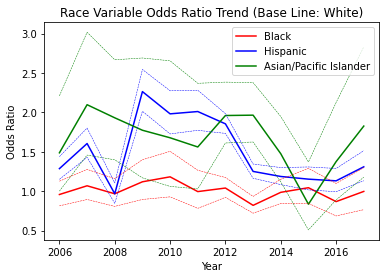

In [14]:
# plot
import seaborn as sns
years = list(range(2006, 2018))
sns.lineplot(x = years, y = black, color = 'red', label="Black")
sns.lineplot(x = years, y = hispanic, color = 'blue', label="Hispanic")
sns.lineplot(x = years, y = asianpacific, color = 'green', label="Asian/Pacific Islander")

sns.lineplot(x = years, y = black_low, color = 'red', linestyle='--',linewidth =0.5)
sns.lineplot(x = years, y = hispanic_low, color = 'blue', linestyle='--',linewidth =0.5)
sns.lineplot(x = years, y = asianpacific_low, color = 'green', linestyle='--',linewidth =0.5)

sns.lineplot(x = years, y = black_high, color = 'red', linestyle='--',linewidth =0.5)
sns.lineplot(x = years, y = hispanic_high, color = 'blue', linestyle='--',linewidth =0.5)
sns.lineplot(x = years, y = asianpacific_high, color = 'green', linestyle='--',linewidth =0.5)

plt.title('Race Variable Odds Ratio Trend (Base Line: White)')
plt.xlabel('Year')
plt.ylabel('Odds Ratio')
plt.legend()
plt.savefig('Race_Odds_Ratio_Trend(Single Speeding)')
plt.show()

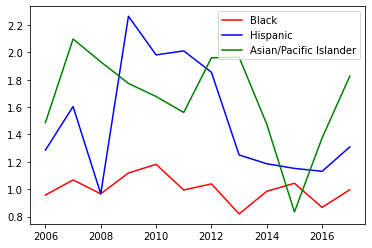

In [15]:
years = list(range(2006, 2018))
sns.lineplot(x = years, y = black, color = 'red', label="Black")
sns.lineplot(x = years, y = hispanic, color = 'blue', label="Hispanic")
sns.lineplot(x = years, y = asianpacific, color = 'green', label="Asian/Pacific Islander")

In [16]:
# first create folder and write to csv files
file_name = 'baseline_overlimit_yearwise.csv'
save_path = '/gdrive/MyDrive/traffic_stop/output_0131/' + file_name
res_df.to_csv(save_path)

#### speeding-over-limit interaction

In [34]:
var_lst_interaction = ['subject_race_black', 'subject_race_hispanic', 'subject_race_asian/pacific islander',
                    'holiday', 'county_type_Metropolitan', 'county_type_Micropolitan',
                    'hispanic_metro','black_metro','asian/paci_metro']

#var_lst_baseline = ['subject_race_black', 'subject_race_hispanic', 'subject_race_asian/pacific islander',
                    #'holiday', 'county_type_Metropolitan', 'county_type_Micropolitan']

# num_feat = len(df_16.columns)

# this df is later pass into run_year_analysis to get all estimates
df_years = pd.DataFrame({'variable':var_lst_interaction})
#df_years = pd.DataFrame({'variable':var_lst_baseline})

# keep track of coefficient estimates and evaluation metrics
asianpacific = []	
black = []	
hispanic = []	

asianpacific_low = []	
black_low = []	
hispanic_low = []

asianpacific_high = []	
black_high = []	
hispanic_high = []

In [35]:
data_path = '/gdrive/MyDrive/traffic_stop/year_data_preprocessed/'
res_df = run_year_analysis(data_path, output_path = ' ', df_years = df_years, school = False, model = 'interaction')

***********************************
2006
# speeding over limit:  759993
Index(['holiday', 'subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_race_white',
       'county_type_Metropolitan', 'county_type_Micropolitan',
       'county_type_Non core'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.018488
         Iterations 10
***********************************
2007
# speeding over limit:  692057
Index(['holiday', 'subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_race_white',
       'county_type_Metropolitan', 'county_type_Micropolitan',
       'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.016760
         Iterations 10
***********************************
2008
# speeding over limit:  756961
Index(['holiday', 'subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_race_white',
       'county_type_Metropolitan', 'county_type_Micropolitan',
       'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.016720
         Iterations 10
***********************************
2009
# spee

In [36]:
res_df

,variable,coef_2006,odds_ratio_2006,OR_lower_CI_2006,OR_upper_CI_2006,pvalue_2006,coef_2007,odds_ratio_2007,OR_lower_CI_2007,OR_upper_CI_2007,pvalue_2007,coef_2008,odds_ratio_2008,OR_lower_CI_2008,OR_upper_CI_2008,pvalue_2008,coef_2009,odds_ratio_2009,OR_lower_CI_2009,OR_upper_CI_2009,pvalue_2009,coef_2010,odds_ratio_2010,OR_lower_CI_2010,OR_upper_CI_2010,pvalue_2010,coef_2011,odds_ratio_2011,OR_lower_CI_2011,OR_upper_CI_2011,pvalue_2011,coef_2012,odds_ratio_2012,OR_lower_CI_2012,OR_upper_CI_2012,pvalue_2012,coef_2013,odds_ratio_2013,OR_lower_CI_2013,OR_upper_CI_2013,pvalue_2013,coef_2014,odds_ratio_2014,OR_lower_CI_2014,OR_upper_CI_2014,pvalue_2014,coef_2015,odds_ratio_2015,OR_lower_CI_2015,OR_upper_CI_2015,pvalue_2015,coef_2016,odds_ratio_2016,OR_lower_CI_2016,OR_upper_CI_2016,pvalue_2016,coef_2017,odds_ratio_2017,OR_lower_CI_2017,OR_upper_CI_2017,pvalue_2017
0,subject_race_black,0.082326,1.085810,0.855091,1.378781,4.993658e-01,0.092635,1.097061,0.830466,1.449238,5.143044e-01,0.061486,1.063415,0.834146,1.355700,6.197064e-01,0.330165,1.391197,1.019815,1.897825,3.717832e-02,0.358146,1.430674,1.018993,2.008678,3.858027e-02,-0.198778,0.819732,0.548172,1.225822,3.329393e-01,0.083971,1.087597,0.927636,1.275142,3.008869e-01,-0.152397,0.858647,0.738678,0.998100,4.717437e-02,-0.002197,0.997806,0.816993,1.218635,9.828187e-01,-0.158279,0.853611,0.618011,1.179028,3.367896e-01,-0.283372,0.753240,0.546330,1.038511,8.374612e-02,-0.229894,0.794618,0.551875,1.144131,2.164449e-01
1,subject_race_hispanic,0.416467,1.516595,1.300832,1.768144,1.043723e-07,0.477330,1.611766,1.364789,1.903436,1.858815e-08,-0.221807,0.801070,0.671366,0.955833,1.384727e-02,0.903101,2.467242,2.100940,2.897409,3.290052e-28,0.798767,2.222799,1.835421,2.691935,2.946281e-16,0.975617,2.652804,2.238036,3.144440,2.399872e-29,0.695329,2.004369,1.838661,2.185010,3.463802e-56,0.223957,1.251018,1.148838,1.362286,2.582969e-07,0.241547,1.273217,1.138946,1.423319,2.156120e-05,0.277307,1.319571,1.119070,1.555995,9.743433e-04,0.169352,1.184537,1.011306,1.387442,3.578753e-02,0.213804,1.238380,1.037192,1.478594,1.809490e-02
2,subject_race_asian/pacific islander,0.415622,1.515313,0.810717,2.832273,1.927757e-01,0.390296,1.477418,0.734121,2.973302,2.740508e-01,0.738163,2.092089,1.354985,3.230176,8.662329e-04,0.317926,1.374275,0.649161,2.909344,4.060691e-01,0.687573,1.988883,1.021385,3.872836,4.315617e-02,0.435350,1.545504,0.795133,3.004006,1.991792e-01,0.918001,2.504279,1.959250,3.200927,2.289069e-13,0.788871,2.200909,1.757981,2.755435,5.949737e-12,0.550911,1.734832,1.223738,2.459385,1.975603e-03,-0.118706,0.888068,0.440434,1.790654,7.400690e-01,0.525426,1.691179,1.009195,2.834027,4.607423e-02,0.717838,2.049996,1.198588,3.506197,8.754674e-03
3,holiday,-0.128573,0.879349,0.804536,0.961119,4.595411e-03,-0.198957,0.819586,0.742996,0.904071,7.048286e-05,-0.043529,0.957405,0.872242,1.050883,3.597772e-01,-0.221266,0.801504,0.715857,0.897397,1.242912e-04,-0.141884,0.867722,0.761798,0.988374,3.267847e-02,0.047965,1.049134,0.931108,1.182120,4.308649e-01,-0.070844,0.931607,0.874343,0.992622,2.861426e-02,0.042022,1.042917,0.979260,1.110713,1.909625e-01,-0.020529,0.979680,0.902404,1.063575,6.243463e-01,-0.050044,0.951187,0.845271,1.070376,4.060592e-01,0.069646,1.072128,0.950861,1.208861,2.554477e-01,-0.076206,0.926626,0.806808,1.064237,2.807235e-01
4,county_type_Metropolitan,0.188788,1.207784,1.076861,1.354626,1.260168e-03,0.020228,1.020434,0.899124,1.158110,7.540894e-01,-0.407971,0.664998,0.593110,0.745600,2.762369e-12,-0.130138,0.877974,0.744226,1.035759,1.227571e-01,-0.117047,0.889543,0.738778,1.071076,2.167198e-01,-0.236419,0.789450,0.667403,0.933815,5.795646e-03,-0.709295,0.491991,0.451306,0.536343,2.303462e-58,-1.239922,0.289407,0.264031,0.317221,1.542059e-154,-0.730725,0.481560,0.430132,0.539136,7.511889e-37,-0.352380,0.703013,0.599435,0.824488,1.469724e-05,-0.757516,0.468830,0.394930,0.556558,4.906350e-18,-0.839739,0.431823,0.348781,0.534637,1.294668e-14
5,county_type_Micropolitan,0.010268,1.

In [21]:
# first create folder
file_name = 'interaction_overlimit_yearwise.csv'
save_path = '/gdrive/MyDrive/traffic_stop/output_0131/' + file_name
res_df.to_csv(save_path)

Text(0, 0.5, 'odds ratio')

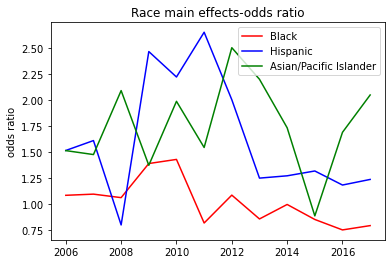

In [37]:
years = list(range(2006, 2018))
sns.lineplot(x = years, y = black, color = 'red', label="Black")
sns.lineplot(x = years, y = hispanic, color = 'blue', label="Hispanic")
sns.lineplot(x = years, y = asianpacific, color = 'green', label="Asian/Pacific Islander")
plt.title('Race main effects-odds ratio')
plt.ylabel('odds ratio')

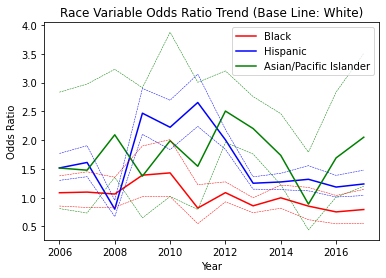

In [23]:
# plot
import seaborn as sns
years = list(range(2006, 2018))
sns.lineplot(x = years, y = black, color = 'red', label="Black")
sns.lineplot(x = years, y = hispanic, color = 'blue', label="Hispanic")
sns.lineplot(x = years, y = asianpacific, color = 'green', label="Asian/Pacific Islander")

sns.lineplot(x = years, y = black_low, color = 'red', linestyle='--',linewidth=0.5)
sns.lineplot(x = years, y = hispanic_low, color = 'blue', linestyle='--',linewidth=0.5)
sns.lineplot(x = years, y = asianpacific_low, color = 'green', linestyle='--',linewidth=0.5)

sns.lineplot(x = years, y = black_high, color = 'red', linestyle='--',linewidth=0.5)
sns.lineplot(x = years, y = hispanic_high, color = 'blue', linestyle='--',linewidth=0.5)
sns.lineplot(x = years, y = asianpacific_high, color = 'green', linestyle='--',linewidth=0.5)

plt.title('Race Variable Odds Ratio Trend (Base Line: White)')
plt.xlabel('Year')
plt.ylabel('Odds Ratio')
plt.legend()
plt.savefig('Race_Odds_Ratio_Trend(Single Speeding)')
plt.show()

In [38]:
compound_black = pd.Series(res_df.loc[res_df['variable'] == 'subject_race_black',:].iloc[0,1:]) + pd.Series(res_df.loc[res_df['variable'] == 'black_metro',:].iloc[0,1:])
compound_hispanic = pd.Series(res_df.loc[res_df['variable'] == 'subject_race_hispanic',:].iloc[0,1:]) + pd.Series(res_df.loc[res_df['variable'] == 'hispanic_metro',:].iloc[0,1:])
compound_asianpacific = pd.Series(res_df.loc[res_df['variable'] == 'subject_race_asian/pacific islander',:].iloc[0,1:]) + pd.Series(res_df.loc[res_df['variable'] == 'asian/paci_metro',:].iloc[0,1:])

In [39]:
idxs = []
for year in list(range(2006,2018)):
  idxs.append(('coef_' + str(year)))
compound_black = [np.exp(x) for x in compound_black[idxs]]
compound_hispanic = [np.exp(x) for x in compound_hispanic[idxs]]
compound_asianpacific = [np.exp(x) for x in compound_asianpacific[idxs]]

In [ ]:
# ignore this cell, wrong calculation
#compound_black = compound_black[['odds_ratio_2006','odds_ratio_2007','odds_ratio_2008','odds_ratio_2009',
                                 #'odds_ratio_2010', 'odds_ratio_2011', 'odds_ratio_2012', 'odds_ratio_2013',
                                 #'odds_ratio_2014', 'odds_ratio_2015', 'odds_ratio_2016', 'odds_ratio_2017']]
#compound_hispanic = compound_hispanic[['odds_ratio_2006','odds_ratio_2007','odds_ratio_2008','odds_ratio_2009',
                                 #'odds_ratio_2010', 'odds_ratio_2011', 'odds_ratio_2012', 'odds_ratio_2013',
                                 #'odds_ratio_2014', 'odds_ratio_2015', 'odds_ratio_2016', 'odds_ratio_2017']]
#compound_asianpacific = compound_asianpacific[['odds_ratio_2006','odds_ratio_2007','odds_ratio_2008','odds_ratio_2009',
                                 #'odds_ratio_2010', 'odds_ratio_2011', 'odds_ratio_2012', 'odds_ratio_2013',
                                 #'odds_ratio_2014', 'odds_ratio_2015', 'odds_ratio_2016', 'odds_ratio_2017']]

Text(0, 0.5, 'odds ratio')

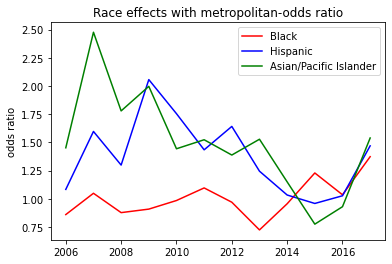

In [40]:
years = list(range(2006, 2018))
sns.lineplot(x = years, y = compound_black, color = 'red', label="Black")
sns.lineplot(x = years, y = compound_hispanic, color = 'blue', label="Hispanic")
sns.lineplot(x = years, y = compound_asianpacific, color = 'green', label="Asian/Pacific Islander")
plt.title('Race effects with metropolitan-odds ratio')
plt.ylabel('odds ratio')

#### School zone baseline

In [41]:
data_path = '/gdrive/MyDrive/traffic_stop/year_data_preprocessed/'
res_df = run_year_analysis(data_path, output_path = ' ', df_years = df_years, school = True, model = 'baseline')

***********************************
school zone
# of school zone speeding: 19476
1    10422
0     9054
Name: citation_issued, dtype: int64
Index(['holiday', 'subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_race_white',
       'county_type_Metropolitan', 'county_type_Micropolitan',
       'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.672203
         Iterations 5


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [42]:
res_df

,variable,coef,odds_ratio,lower_CI,upper_CI,pvalue
0,const,-0.237826,0.788340,0.731886,0.849149,3.536245e-10
1,holiday,-0.997199,0.368911,0.318063,0.427889,1.167011e-39
2,subject_race_asian/pacific islander,0.383136,1.466877,1.199392,1.794015,1.914554e-04
3,subject_race_black,0.279726,1.322768,1.188751,1.471893,2.861225e-07
4,subject_race_hispanic,0.349940,1.418983,1.332250,1.511362,1.523453e-27
5,county_type_Metropolitan,0.505401,1.657650,1.528693,1.797485,2.120994e-34
6,county_type_Micropolitan,-0.144525,0.865433,0.788361,0.950041,2.390439e-03


#### School zone interaction

In [43]:
data_path = '/gdrive/MyDrive/traffic_stop/year_data_preprocessed/'
res_df = run_year_analysis(data_path, output_path = ' ', df_years = df_years, school = True, model = 'interaction')

***********************************
school zone
# of school zone speeding: 19476
1    10422
0     9054
Name: citation_issued, dtype: int64
Index(['holiday', 'subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_race_white',
       'county_type_Metropolitan', 'county_type_Micropolitan',
       'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.668873
         Iterations 5


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [44]:
res_df

,variable,coef,odds_ratio,lower_CI,upper_CI,pvalue
0,const,-0.127375,0.880403,0.814547,0.951585,1.322775e-03
1,holiday,-1.006750,0.365405,0.314758,0.424201,6.299906e-40
2,subject_race_asian/pacific islander,0.268542,1.308056,0.785468,2.178331,3.020774e-01
3,subject_race_black,0.247438,1.280740,1.061123,1.545811,9.934266e-03
4,subject_race_hispanic,-0.073104,0.929505,0.843241,1.024593,1.412715e-01
5,county_type_Metropolitan,0.290890,1.337618,1.219953,1.466632,5.946431e-10
6,county_type_Micropolitan,-0.049704,0.951511,0.865767,1.045747,3.022692e-01
7,hispanic_metro,0.735875,2.087308,1.835011,2.374292,4.276360e-29
8,black_metro,0.076624,1.079636,0.859509,1.356138,5.101312e-01
9,asian/paci_metro,0.209503,1.233065,0.707761,2.148251,4.595125e-01


### Demographic Distribution for search_conducted under  only speeding violation

In [46]:
def remove_duplicates(row):
  if row['speeding_only'] == 'speeding-repeated_entries':
    return row['all_violation'][0].strip()
  else:
    return row['violation']

def exclusive(vio_lst):
  count = 0
  for vio in vio_lst:
    # count number of violations containing 'speed'
    if 'speed' in vio:
      count += 1
  # if only 1 speeding-related violation, return 1
  # if all of the violations (for this record) include speeding and more than 1 violation, return 2
  # if include violations other than speeding, return 3
  if count == 1 and count == len(vio_lst):
    return 'speeding-1'
  elif count == len(vio_lst):
    if len(vio_lst) == len(set(vio_lst)):
      return 'speeding-repeated_entries'
    return 'speeding-multiple'
  elif count < len(vio_lst):
    return 'speeding+others'

In [ ]:
# For each year:
# filter out speeding-1 & repeated entries
# filter out search-conducted = True
# use another df to concat each year's df together

# see how contraband found is distributed
# plot percentage of different race

In [48]:
keep_col = ['date', 
                'time', 
                'county_name', 
                'subject_race',
                'subject_sex',
                'violation', 
                'citation_issued',
                'contraband_found',
                'contraband_drugs',
                'contraband_weapons',
                'search_conducted',
                'search_vehicle',
                'lat',
                'lng'
                ]

In [50]:
df_search = pd.Series([0]*4, index = ['white','hispanic','black','asian/pacific islander'])
df_all = pd.Series([0]*4, index = ['white','hispanic','black','asian/pacific islander'])

years = []
for i in range(2006, 2018):
  years.append(str(i))

for year in years:

  file_name = '/gdrive/MyDrive/traffic_stop/year_data/traffic_' + year + '.parquet'
  df = pd.read_parquet(file_name, engine = 'pyarrow')

  # drop unrelated columns
  #df.drop(col_drop, axis = 1, inplace = True)
  df = df[keep_col]

  df['violation'] = [s.lower() for s in df['violation']]
  df = df.loc[df['violation'].str.contains('speed', regex = False),:]
  df['violation'] = df['violation'].map(lambda x: x.replace('(#)',''))
  df['violation'] = df['violation'].map(lambda x: x.strip())

  # get a list of violations for each record, and apply self-defined func exclusive
  df['all_violation'] = df['violation'].str.split('|')
  df['speeding_only'] = df['all_violation'].map(lambda x: exclusive(x))

  print('*****************************************************')
  print(year)
  print('All speeding related records: ', len(df))
  print('Types: ')
  print(df['speeding_only'].value_counts())

  # filter out rows with violations other than speeding
  df = df.loc[df['speeding_only'].isin(['speeding-repeated_entries','speeding-1', 'speeding-multiple'])]
  print('All speeding related (No other violations) records: ', len(df))

  for col in ['contraband_found','search_conducted']:
    df[col] = df[col].map({True: 1, False: 0, None: 0})

  # filter out search_conducted = True
  for race in ['white','hispanic','black','asian/pacific islander']:
    df_all[race] += len(df.loc[df['subject_race'] == race,:])
    df_search[race] += len(df.loc[((df['search_conducted'] == 1) & (df['subject_race'] == race)),:])
  # print('# Search conducted in speeding-only records: ', len(df))
  print('*****************************************************')

*****************************************************
2006
All speeding related records:  1715076
Types: 
speeding-1                   1245007
speeding+others               469779
speeding-repeated_entries        290
Name: speeding_only, dtype: int64
All speeding related (No other violations) records:  1245297
*****************************************************
*****************************************************
2007
All speeding related records:  1537512
Types: 
speeding-1                   1121125
speeding+others               416091
speeding-repeated_entries        296
Name: speeding_only, dtype: int64
All speeding related (No other violations) records:  1121421
*****************************************************
*****************************************************
2008
All speeding related records:  1579295
Types: 
speeding-1                   1160941
speeding+others               417918
speeding-repeated_entries        436
Name: speeding_only, dtype: int64
All speeding rela

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*****************************************************
*****************************************************
2011
All speeding related records:  1502403
Types: 
speeding-1                   1122948
speeding+others               378562
speeding-repeated_entries        892
speeding-multiple                  1
Name: speeding_only, dtype: int64
All speeding related (No other violations) records:  1123841
*****************************************************
*****************************************************
2012
All speeding related records:  1413641
Types: 
speeding-1                   1057323
speeding+others               355535
speeding-repeated_entries        783
Name: speeding_only, dtype: int64
All speeding related (No other violations) records:  1058106
*****************************************************
*****************************************************
2013
All speeding related records:  1253476
Types: 
speeding-1                   933361
speeding+others              319494

In [51]:
df_search.head()

white                     32294
hispanic                  21983
black                     11023
asian/pacific islander      768
dtype: int64

In [52]:
df_all.head()

white                     7670258
hispanic                  2900079
black                     1057167
asian/pacific islander     215240
dtype: int64

In [54]:
search_pct = df_search.divide(df_all)
search_pct

white                     0.004210
hispanic                  0.007580
black                     0.010427
asian/pacific islander    0.003568
dtype: float64

In [ ]:
search_pct.sort_index(inplace = True)

Text(0.5, 1.0, 'Race Distribution in Speeding-Only')

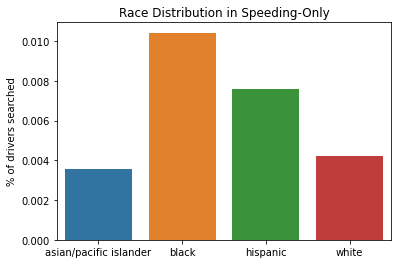

In [ ]:
sns.barplot(x=list(search_pct.index), y=search_pct)
plt.ylabel('% of drivers searched')
plt.title('Race Distribution in Speeding-Only')

### Demographic distribution of search_conducted for citation rate low categories of speeding

In [ ]:
df_search = pd.DataFrame()
df_all = pd.Series([0]*4, index = ['white','hispanic','black','asian/pacific islander'])
years = []
for i in range(2006, 2018):
  years.append(str(i))

for year in years:
  file_name = '/gdrive/MyDrive/traffic_stop/year_data_preprocessed/traffic_' + year + '.parquet'
  df = pd.read_parquet(file_name, engine = 'pyarrow')
  df['subject_race'] = df.subject_race.cat.remove_unused_categories()
  print('*****************************************************')
  print(year)
  print('All speeding related (No other violations) records: ', len(df))
  for race in ['white','hispanic','black','asian/pacific islander']:
    df_all[race] += df['subject_race'].value_counts()[race]
  # filter out search_conducted = True
  df = df.loc[df['search_conducted'] == True,:]
  print('# Search conducted in speeding-only records: ', len(df))
  print('*****************************************************')

  # concat all years together:
  df_search = pd.concat([df_search, df], ignore_index = True)

print('# Search conducted in speeding-only records in all years: ', len(df_search))

*****************************************************
2006
All speeding related (No other violations) records:  765096
# Search conducted in speeding-only records:  4888
*****************************************************
*****************************************************
2007
All speeding related (No other violations) records:  696236
# Search conducted in speeding-only records:  3950
*****************************************************
*****************************************************
2008
All speeding related (No other violations) records:  761630
# Search conducted in speeding-only records:  4501
*****************************************************
*****************************************************
2009
All speeding related (No other violations) records:  755217
# Search conducted in speeding-only records:  4054
*****************************************************
*****************************************************
2010
All speeding related (No other violations) re

Text(0.5, 1.0, 'Race Distribution in Speeding-Only & Search Conducted')

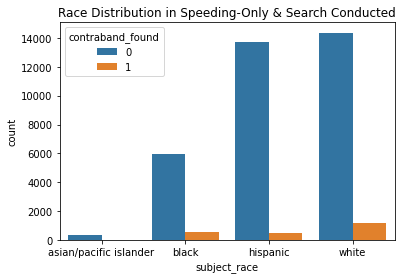

In [ ]:
# plot
#df_search['subject_race'] = df_search.subject_race.cat.remove_unused_categories()
sns.countplot(x="subject_race", hue="contraband_found", data=df_search)
plt.title('Race Distribution in Speeding-Only & Search Conducted')

In [ ]:
# if we use percentage of search_conducted/all drivers stopped & only speeding
df_search['subject_race'].value_counts()

white                     15512
hispanic                  14226
black                      6478
asian/pacific islander      365
Name: subject_race, dtype: int64

In [ ]:
df_all

white                     5428440
hispanic                  1893840
black                      697569
asian/pacific islander     116818
dtype: int64

In [ ]:
search_pct = df_search['subject_race'].value_counts().divide(df_all)
search_pct

white                     0.002858
hispanic                  0.007512
black                     0.009287
asian/pacific islander    0.003125
dtype: float64

In [ ]:
search_pct.sort_index(inplace = True)

Text(0.5, 1.0, 'Race Distribution in Speeding-Only (Low-Citation Categories)')

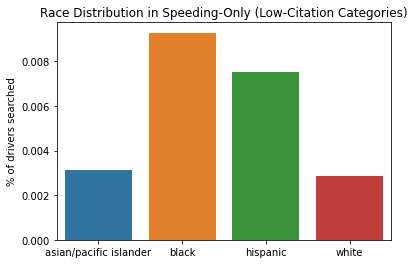

In [ ]:
sns.barplot(x=list(search_pct.index), y=search_pct)
plt.ylabel('% of drivers searched')
plt.title('Race Distribution in Speeding-Only (Low-Citation Categories)')

### Demographic (race) distribution for the only violation is 'speeding over limit' category

In [ ]:
df_limit = pd.Series([0]*4, index = ['white','hispanic','black','asian/pacific islander'])
df_all = pd.Series([0]*4, index = ['white','hispanic','black','asian/pacific islander'])

years = []
for i in range(2006, 2018):
  years.append(str(i))

for year in years:

  file_name = '/gdrive/MyDrive/traffic_stop/year_data/traffic_' + year + '.parquet'
  df = pd.read_parquet(file_name, engine = 'pyarrow')

  # drop unrelated columns
  #df.drop(col_drop, axis = 1, inplace = True)
  df = df[keep_col]

  df['violation'] = [s.lower() for s in df['violation']]
  df = df.loc[df['violation'].str.contains('speed', regex = False),:]
  df['violation'] = df['violation'].map(lambda x: x.replace('(#)',''))
  df['violation'] = df['violation'].map(lambda x: x.strip())

  # get a list of violations for each record, and apply self-defined func exclusive
  df['all_violation'] = df['violation'].str.split('|')
  df['speeding_only'] = df['all_violation'].map(lambda x: exclusive(x))

  print('*****************************************************')
  print(year)
  print('All speeding related records: ', len(df))
  print('Types: ')
  print(df['speeding_only'].value_counts())

  # filter out rows with violations other than speeding
  df = df.loc[df['speeding_only'].isin(['speeding-repeated_entries','speeding-1'])]
  df['violation'] = df.apply(lambda row: remove_duplicates(row), axis = 1)
  df['violation'] = df['violation'].map(lambda x: x.strip())

  print('All speeding related (No other violations) records: ', len(df))

  for col in ['contraband_found','search_conducted']:
    df[col] = df[col].map({True: 1, False: 0, None: 0})

  # filter out search_conducted = True
  for race in ['white','hispanic','black','asian/pacific islander']:
    df_all[race] += len(df.loc[df['subject_race'] == race,:])
    df_limit[race] += len(df.loc[((df['violation'] == 'speeding over limit') & (df['subject_race'] == race)),:])
  # print('# Search conducted in speeding-only records: ', len(df))
  print('*****************************************************')

*****************************************************
2006
All speeding related records:  1715076
Types: 
speeding-1                   1245007
speeding+others               469779
speeding-repeated_entries        290
Name: speeding_only, dtype: int64
All speeding related (No other violations) records:  1245297
*****************************************************
*****************************************************
2007
All speeding related records:  1537512
Types: 
speeding-1                   1121125
speeding+others               416091
speeding-repeated_entries        296
Name: speeding_only, dtype: int64
All speeding related (No other violations) records:  1121421
*****************************************************
*****************************************************
2008
All speeding related records:  1579295
Types: 
speeding-1                   1160941
speeding+others               417918
speeding-repeated_entries        436
Name: speeding_only, dtype: int64
All speeding rela

In [ ]:
df_limit

white                     5419386
hispanic                  1888008
black                      695099
asian/pacific islander     116310
dtype: int64

In [ ]:
df_all

white                     7670256
hispanic                  2900077
black                     1057167
asian/pacific islander     215240
dtype: int64

In [ ]:
limit_pct = df_limit.divide(df_all)
limit_pct

white                     0.706546
hispanic                  0.651020
black                     0.657511
asian/pacific islander    0.540374
dtype: float64

In [ ]:
limit_pct.sort_index(inplace = True)

Text(0.5, 1.0, 'Race Distribution: only "speeding over limit"')

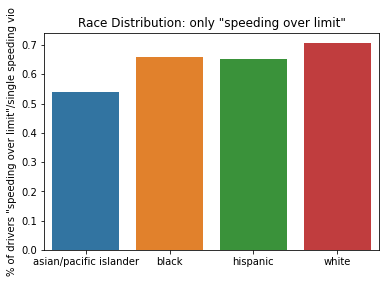

In [ ]:
sns.barplot(x=list(limit_pct.index), y=limit_pct)
plt.ylabel('% of drivers "speeding over limit"/single speeding vio')
plt.title('Race Distribution: only "speeding over limit"')